# Feature evaluation
This notebook explores the engeineered features.

## Load dependencies

In [21]:
import os
import json
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from IPython.core.display import display

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance

from definitions import GEN_PATH, ROOT_DIR

## Load processed data

In [2]:
# Read configuration file
with open(os.path.join(ROOT_DIR, 'config.json')) as f:
    config = json.load(f)

proc_match_filepath = os.path.join(GEN_PATH, config['proc_match_filename'])

# Read data
data = pd.read_hdf(proc_match_filepath, key='matches')

## Extract training (and validation) data
Test data should not be used, even in, feature evaluation.

In [3]:
# Split data set into train and test
# Start of 2019 season in unix time, 2018-12-31 00:00:00 UTC
test_date_begin = 1546214400
# change to date to tourney_date and add tourney_level
drop_cols = ['outcome', 'date']

# Testing will be done on 2019 matches
data_train = data.loc[data.date < test_date_begin]
y_train = data_train.outcome
X_train = data_train.drop(drop_cols, axis=1)

# Correlation heatmap

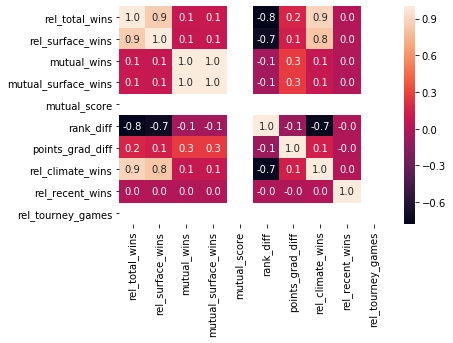

In [9]:
X_heat = X_train.drop('home_advantage', axis=1)
sn.heatmap(X_heat.corr(), annot=True, fmt='.1f')
plt.show()

Train base model to be used for feature selection

In [ ]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

## Feature importance
Question being answered: which features help split our tree in the best way possible?

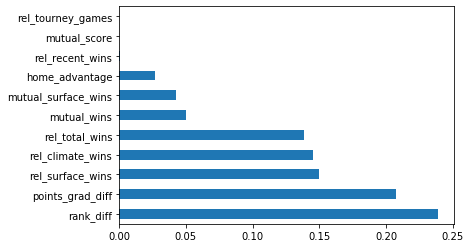

In [18]:
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.sort_values(ascending=False).plot(kind='barh')
plt.show()

## Recursive feature elimination by feature importance
This takes a bit of time (large set...). 
Prune the results from previous sections. 
A ranking of 1 means the algorithm suggests the feature.

In [19]:
rfe_model = RFE(model)  # selects 5 features
rfe_model.fit(X_train, y_train)

rfe_results = pd.DataFrame(rfe_model.ranking_, index=X_train.columns, columns=['ranking'])

display(rfe_results)
print('\nNumber of features selected: %d' % rfe_model.n_features_)

,ranking
rel_total_wins,1
rel_surface_wins,1
mutual_wins,2
mutual_surface_wins,3
mutual_score,7
rank_diff,1
points_grad_diff,1
home_advantage,4
rel_climate_wins,1
rel_recent_wins,5



Number of features selected: 5


# Permutation importance
How does each feature affect the accuracy of our model?

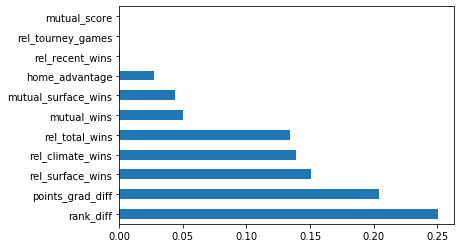

In [22]:
perm_results = permutation_importance(model, X_train, y_train, scoring='accuracy')

means = pd.Series(model.feature_importances_, index=X_train.columns)
means.sort_values(ascending=False).plot(kind='barh')
plt.show()